# Import the needed libraries
- pandas and numpy are used for storing, cleansing, and analyising the finacial records
- yfinance is used for downloading finacial historical data from Yahoo
- threading is used to handle concurrent processing of downloading data with yfinance to boost performance
- logging is used to record long processes progress into a logfile
- matplotlib is used to plot the data on the graph, i.e. visualization of data

In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import threading
import logging
import time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# Enable and setup logging

In [12]:
logging.basicConfig(level=logging.INFO, filename='portfolio_builder.log',
                    filemode='w', format='%(asctime)s %(levelname)s:%(message)s')

# Define the procedures/functions/classes for downloading tickers' information from Yahoo

In [10]:
  
def getValue(info, key):
    if(key in info): 
        return info[key]
    else:
        return np.nan
    
def save2csv(tickersInfo, filename):
    selected_keys= yf.Ticker('msft').info.keys()
    tickersFrame = pd.DataFrame(data=[],columns=selected_keys)

    for t in tickersInfo:
        s={key: getValue(t, key) for key in selected_keys}
        tickersFrame=tickersFrame.append(s, ignore_index=True)

    tickersFrame.set_index(['symbol'], inplace=True)
    tickersFrame.sort_index(inplace=True)
    tickersFrame.to_csv(filename)

class DownloadThread (threading.Thread):
    tickersInfo=[] # all tickers Information downloaded from yahoo accumulated here

    def __init__(self, threadID, name, arange, yftickers):
      threading.Thread.__init__(self)
      self.threadID = threadID
      self.name = name
      self.arange = arange
      self.yftickers=yftickers
        
    def run(self):
      logging.info("Starting " + self.name + ' in ' + str(self.arange))
      self.appendToTickersInfo()
      logging.info("Exiting " + self.name)
    
    def appendToTickersInfo(self):
        for t in self.arange:
            try:
                if (t%100==0): logging.info("Adding tickers[" + str(t) + "]")
                DownloadThread.tickersInfo.append(self.yftickers.tickers[t].info)
            except:
                logging.info("Ticker " + self.yftickers.tickers[t].ticker.title() + " is skipped due to yfinance exception.")
                pass
            
def loadTickersInfoFromYahoo(tickersFrame: pd.DataFrame, batchSize: int):
    yftickers=yf.Tickers(tickersFrame.Tickers.to_list())
    logging.info('There are ' + str(len(yftickers.tickers)) + ' tickers to be loaded in background threads.')
    threads = [DownloadThread(i,'T'+str(i),range(batchSize*i,min(batchSize*(i+1),tickersFrame.shape[0])),yftickers) 
               for i in range(int(len(yftickers.tickers) / batchSize)+1)]
    DownloadThread.tickersInfo=[]
    for t in threads:
        t.start() # start all threads
    for t in threads:
        t.join() # wait until all threads completed
    logging.info('There are ' + str(len(DownloadThread.tickersInfo)) + ' tickers info downloaded.')
    return DownloadThread.tickersInfo

# Download tickers' information from Yahoo (Take long time > 30 minutes)
- The list of HK tickers, which information is to be downloaded, are specified on HKTickers.csv
- The resulting tickersInfo is then saved on HKTickersInfo.csv
- It takes time to load all information from Yahoo, please be patient
- Due to unknown reason, some tickers may return error from yfinance calls, these tickers will be skipped (review the portfolio_builder.log for details)

In [13]:
batchSize=100  # number of tickers being processed in a thread
hk_tickers=pd.read_csv('HKTickers.csv')
start_time = time.time()
tickersInfo = loadTickersInfoFromYahoo(hk_tickers, batchSize)
end_time = time.time()
save2csv(tickersInfo, 'HKTickersInfo.csv')
logging.info('Elpase Time: ' + str(end_time-start_time))

# Loading tickers' information from local HKTickersInfo.csv
- To speed up the process, we may start here to process HK Tickers Information

In [14]:
tickersFrame = pd.read_csv('HKTickersInfo.csv')
tickersFrame.shape

(2341, 123)

# Sort out the recommended portfolio (To be implemented)
- 筛选条件：（从小到大排列）
- 总股本：排名的前20%
- 市净率：排名的前20%
- 净利润增长：排名的后30%

## 调仓周期：5
- 最大持仓股票数：5
- 个股仓位权重：平权

In [37]:
selected_keys=['symbol', 'sector', 'industry', 'longName', 'volume', 
                'profitMargins', 'sharesOutstanding', 'regularMarketPreviousClose', 
                'trailingPE', 'priceToBook', 'earningsQuarterlyGrowth']
tickersFrame = pd.read_csv('HKTickersInfo.csv')
# for c in tickersFrame.columns: print(c)
tickersFrame=tickersFrame[selected_keys]
tickersFrame=tickersFrame.dropna()
tickersFrame=tickersFrame.astype({'trailingPE': 'float64'})
tickersFrame['weightedFactors']=(tickersFrame['sharesOutstanding'])/(tickersFrame.max()['sharesOutstanding']) + \
    (tickersFrame['priceToBook'])/(tickersFrame.max()['priceToBook']) + \
    (tickersFrame['earningsQuarterlyGrowth'])/(tickersFrame.max()['earningsQuarterlyGrowth'])
tickersFrame.set_index(['sector','symbol'], inplace=True)
tickersFrame.sort_index(inplace=True)
tickersFrame=tickersFrame.sort_values(by=['sector', 'weightedFactors'], ascending=False).groupby('sector').head(1)
tickersFrame

,,industry,longName,volume,profitMargins,sharesOutstanding,regularMarketPreviousClose,trailingPE,priceToBook,earningsQuarterlyGrowth,weightedFactors
sector,symbol,,,,,,,,,,
Utilities,1250.HK,Utilities—Independent Power Producers,Beijing Enterprises Clean Energy Group Limited,26260000.0,0.18010,6.352540e+10,0.056,2.095588,0.341317,-0.146,0.850309
Technology,2382.HK,Electronic Components,Sunny Optical Technology (Group) Company Limited,9893926.0,0.09286,1.096850e+09,139.500,53.678146,125.608665,0.213,1.020277
Real Estate,0898.HK,Real Estate Services,Multifield International Holdings Limited,4000.0,4.17731,4.180370e+09,0.380,2.168950,0.224985,38.201,1.057820
Industrials,0267.HK,Conglomerates,CITIC Limited,8060089.0,0.07478,2.909030e+10,9.900,5.815029,0.503932,0.081,0.396022
Healthcare,1177.HK,Biotechnology,Sino Biopharmaceutical Limited,31582369.0,0.37177,1.258830e+10,10.220,12.388955,41.280000,-0.029,0.496598
Financial Services,1141.HK,Capital Markets,CMBC Capital Holdings Limited,20420000.0,0.51249,4.768860e+10,0.130,28.113209,3.311111,0.497,0.678528
Energy,2883.HK,Oil & Gas Equipment & Services,China Oilfield Services Limited,45239978.0,0.08343,1.811120e+09,10.520,639.724600,9.898990,10.662,0.382185
Consumer Defensive,0530.HK,Beverages—Wineries & Distilleries,Goldin Financial Holdings Limited,20685000.0,10.35549,6.990650e+09,1.910,10.925819,0.685673,25.721,0.772460
Consumer Cyclical,0136.HK,Internet Retail,HengTen Networks Group Limited,72489950.0,0.17793,7.461170e+10,0.112,64.241040,56.499996,-0.469,1.437533


In [38]:
recommendedPortfolio = tickersFrame.reset_index('sector').index.to_list()
recommendedPortfolio

['1250.HK',
 '2382.HK',
 '0898.HK',
 '0267.HK',
 '1177.HK',
 '1141.HK',
 '2883.HK',
 '0530.HK',
 '0136.HK',
 '0680.HK',
 '0697.HK']

# Gather and calculate the equal weighted portfolio performance

In [39]:
portfolio_history=yf.download(recommendedPortfolio, period='5y')
portfolio_history=portfolio_history.dropna()
portfolio_historical_mean=portfolio_history.mean(axis=1, level=0)

[*********************100%***********************]  11 of 11 completed


# Define procedure to plot the portfolio performance in compare with HSI

In [40]:
def plot2compareHSI(portdata, label):
    hsi=yf.Ticker('^HSI')
    hsidata=hsi.history(period='5y')
    fig=plt.figure()
    fig.set_size_inches(18.5, 10.5)
    plt.plot(hsidata['Close']/hsidata.iloc[0]['Open']-1, linestyle='-', linewidth=1, label='HSI')
    plt.plot(portdata['Close']/portdata.iloc[0]['Open']-1, linestyle='--', linewidth=1, label=label)
    plt.legend()
    plt.show()

# Plot the recommended portfolio performance in compare with HSI

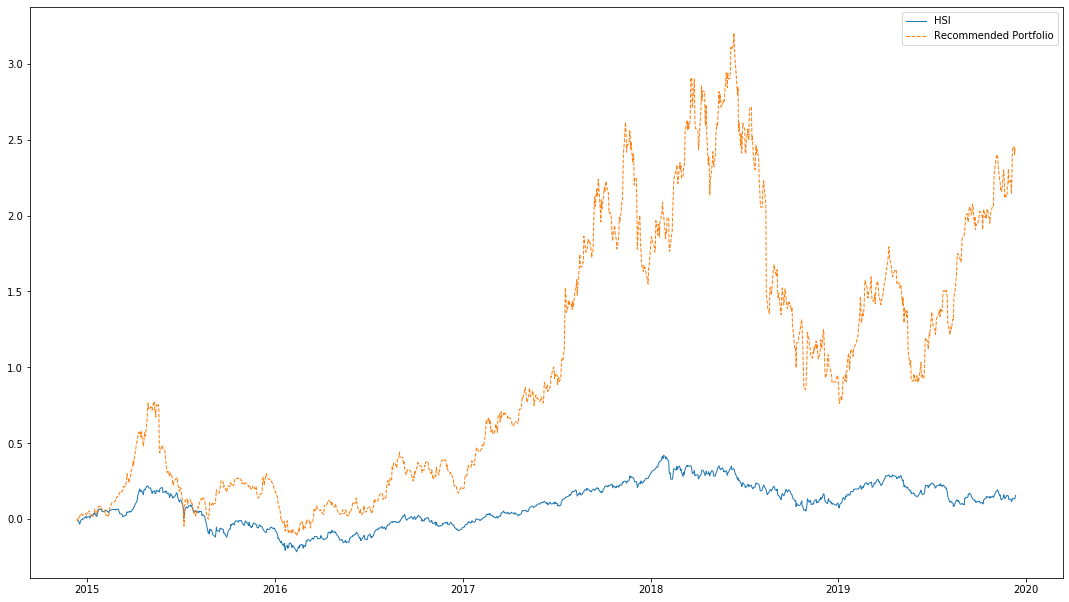

In [30]:
plot2compareHSI(portfolio_historical_mean, 'Recommended Portfolio')